After preprocessing the data, this jupyter notebook to select important features via lightGBM. 

In [1]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from missingpy import KNNImputer

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
path = '../home_credit_data'
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
from memory_profiler import profile

from IPython.display import display, HTML

# from imputer import Imputer
from sklearn.preprocessing import Imputer
from missingpy import KNNImputer
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## 0. Retrieving Data

In [2]:
df = pd.read_csv(path+'/home_credit_processed.csv')

In [3]:
# checking missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total    Percent
REFUSED_RATE_DOWN_PAYMENT_MEAN     303648  85.234287
REFUSED_AMT_DOWN_PAYMENT_MIN       303648  85.234287
REFUSED_RATE_DOWN_PAYMENT_MAX      303648  85.234287
REFUSED_RATE_DOWN_PAYMENT_MIN      303648  85.234287
REFUSED_AMT_DOWN_PAYMENT_MEAN      303648  85.234287
REFUSED_AMT_DOWN_PAYMENT_MAX       303648  85.234287
REFUSED_APP_CREDIT_PERC_VAR        298034  83.658432
CC_AMT_PAYMENT_CURRENT_VAR         284649  79.901249
CC_CNT_DRAWINGS_ATM_CURRENT_VAR    284559  79.875986
CC_AMT_DRAWINGS_ATM_CURRENT_VAR    284559  79.875986
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR  284559  79.875986
CC_CNT_DRAWINGS_POS_CURRENT_VAR    284559  79.875986
CC_AMT_DRAWINGS_POS_CURRENT_VAR    284559  79.875986
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR  284559  79.875986
CC_AMT_PAYMENT_CURRENT_MEAN        284131  79.755846
CC_AMT_PAYMENT_CURRENT_MAX         284131  79.755846
CC_AMT_PAYMENT_CURRENT_MIN         284131  79.755846
CC_AMT_DRAWINGS_OTHER_CURRENT_MAX  284057  79.735074
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN   284057  79.735074
CC_AMT_DRAWINGS_OTHER_CURRENT_MIN  284057  79.735074

## 1. Light GBM feature importance 

In [4]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances092319.png')

### k-fold LightGBM

In [5]:
debug = False
stratified = False
num_folds = 5
submission_file_name = "results092319.csv"

Starting LightGBM. Train shape: (307507, 799), test shape: (48744, 799)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775477	training's binary_logloss: 0.248214	valid_1's auc: 0.763649	valid_1's binary_logloss: 0.250773
[200]	training's auc: 0.789871	training's binary_logloss: 0.239236	valid_1's auc: 0.774013	valid_1's binary_logloss: 0.243577
[300]	training's auc: 0.80018	training's binary_logloss: 0.234562	valid_1's auc: 0.780388	valid_1's binary_logloss: 0.240568
[400]	training's auc: 0.807789	training's binary_logloss: 0.231285	valid_1's auc: 0.783952	valid_1's binary_logloss: 0.238931
[500]	training's auc: 0.813674	training's binary_logloss: 0.228774	valid_1's auc: 0.786395	valid_1's binary_logloss: 0.23787
[600]	training's auc: 0.818572	training's binary_logloss: 0.226662	valid_1's auc: 0.788084	valid_1's binary_logloss: 0.237116
[700]	training's auc: 0.822896	training's binary_logloss: 0.224846	valid_1's auc: 0.789315	valid_1's binary_log

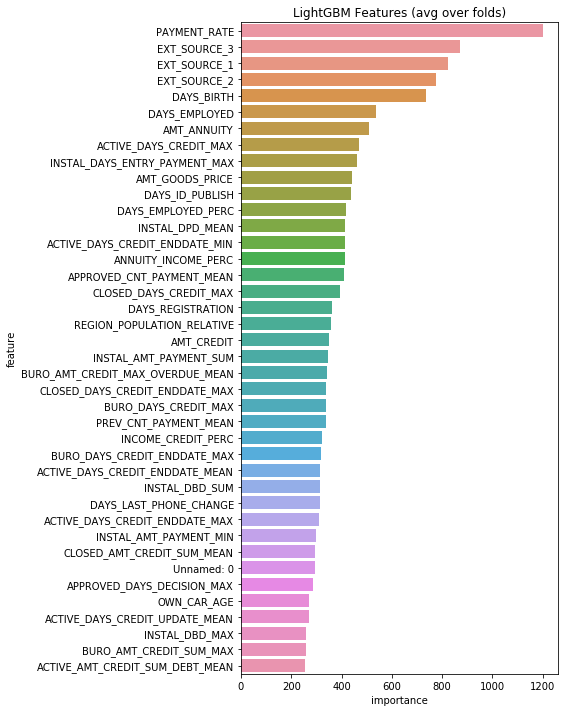

In [6]:
# Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
# =============================================================================
#    clf = LGBMClassifier(
#         nthread=4,
#         n_estimators=10000,
#         learning_rate=0.02,
#         num_leaves=34,
#         colsample_bytree=0.9497036,
#         subsample=0.8715623,
#         max_depth=8,
#         reg_alpha=0.041545473,
#         reg_lambda=0.0735294,
#         min_split_gain=0.0222415,
#         min_child_weight=39.3259775,
#         silent=-1,
#         verbose=-1, )
# =============================================================================
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=56,
        colsample_bytree=0.45,
        subsample=0.91,
        max_depth=5,
        reg_alpha=3.99,
        reg_lambda=0.43,
        min_split_gain=0.077649,
        min_child_weight=32.5443,
        silent=-1,
        verbose=-1, )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
fold_importance_df["fold"] = n_fold + 1
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
del clf, train_x, train_y, valid_x, valid_y
gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
# Write submission file and plot feature importance
if not debug:
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
display_importances(feature_importance_df)

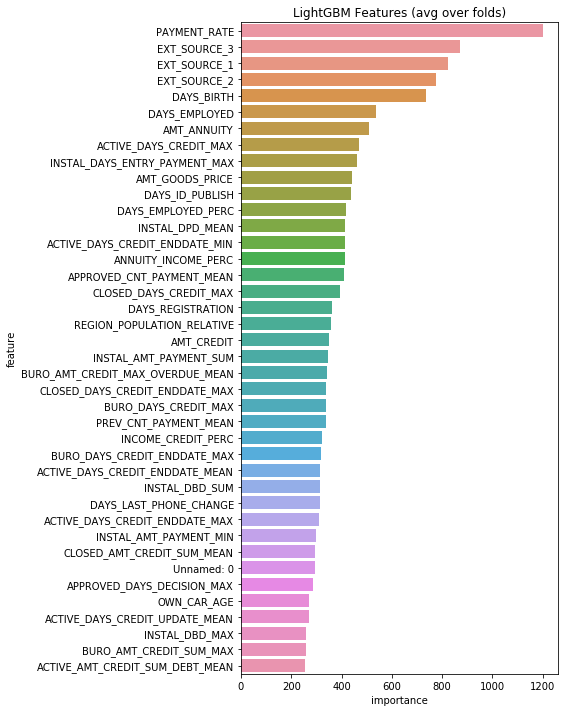

In [7]:
display_importances(feature_importance_df)

In [8]:
feature_importance_df[:10]

feature  importance  fold
0                  Unnamed: 0         293     5
1                 AMT_ANNUITY         511     5
2                  AMT_CREDIT         351     5
3             AMT_GOODS_PRICE         442     5
4            AMT_INCOME_TOTAL         223     5
5   AMT_REQ_CREDIT_BUREAU_DAY           0     5
6  AMT_REQ_CREDIT_BUREAU_HOUR           0     5
7   AMT_REQ_CREDIT_BUREAU_MON          19     5
8   AMT_REQ_CREDIT_BUREAU_QRT          53     5
9  AMT_REQ_CREDIT_BUREAU_WEEK          20     5

In [22]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:150]

In [23]:
cols

importance
feature                                                  
PAYMENT_RATE                                         1201
EXT_SOURCE_3                                          872
EXT_SOURCE_1                                          822
EXT_SOURCE_2                                          776
DAYS_BIRTH                                            735
DAYS_EMPLOYED                                         535
AMT_ANNUITY                                           511
ACTIVE_DAYS_CREDIT_MAX                                469
INSTAL_DAYS_ENTRY_PAYMENT_MAX                         460
AMT_GOODS_PRICE                                       442
DAYS_ID_PUBLISH                                       438
DAYS_EMPLOYED_PERC                                    417
INSTAL_DPD_MEAN                                       415
ACTIVE_DAYS_CREDIT_ENDDATE_MIN                        415
ANNUITY_INCOME_PERC                                   412
APPROVED_CNT_PAYMENT_MEAN                             408
CLOSED_DAYS_CREDIT_MAX                                395
DAYS_REGISTRATION                                     362
REGION_POPULATION_RELATIVE                            359
AMT_CREDIT                                            351
INSTAL_AMT_PAYMENT_SUM                                345
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN                      343
CLOSED_DAYS_CREDIT_ENDDATE_MAX                        340
BURO_DAYS_CREDIT_MAX                                  338
PREV_CNT_PAYMENT_MEAN                                 337
INCOME_CREDIT_PERC                                    322
BURO_DAYS_CREDIT_ENDDATE_MAX                          318
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN                       316
INSTAL_DBD_SUM                                        315
DAYS_LAST_PHONE_CHANGE                                313
...                                                   ...
REFUSED_AMT_CREDIT_MIN                                150
APPROVED_AMT_GOODS_PRICE_MIN                          149
PREV_NAME_CONTRACT_STATUS_Refused_MEAN                149
BURO_STATUS_0_MEAN_MEAN                               147
BURO_AMT_CREDIT_SUM_DEBT_SUM                          146
APPROVED_AMT_CREDIT_MAX                               146
INSTAL_DPD_MAX                                        144
PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN         143
CLOSED_DAYS_CREDIT_ENDDATE_MIN                        142
PREV_AMT_GOODS_PRICE_MIN                              141
REFUSED_DAYS_DECISION_MEAN                            141
CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN                    140
APPROVED_APP_CREDIT_PERC_MAX                          139
APPROVED_APP_CREDIT_PERC_MIN                          138
APPROVED_HOUR_APPR_PROCESS_START_MAX                  136
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN                      136
APPROVED_AMT_CREDIT_MIN                               135
PREV_AMT_APPLICATION_MEAN                             134
TOTALAREA_MODE                                        134
APPROVED_AMT_ANNUITY_MAX                              133
BURO_AMT_CREDIT_SUM_DEBT_MAX                          133
PREV_CNT_PAYMENT_SUM                                  132
BURO_CREDIT_TYPE_Consumer credit_MEAN                 129
PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN           129
CC_CNT_DRAWINGS_CURRENT_VAR                           129
PREV_NAME_CLIENT_TYPE_New_MEAN                        128
BURO_CREDIT_ACTIVE_Active_MEAN                        126
PREV_AMT_ANNUITY_MAX                                  125
INSTAL_DPD_SUM                                        125
POS_SK_DPD_MEAN                                       125

[150 rows x 1 columns]

Save features with large importance to csv file. 

In [24]:
cols.to_csv('features_selected.csv')